# Cummulative Traffic Exposure

In [43]:
# Import libraries

# System

import os

# Analysis

import numpy as np # Numerical Analysis
import pandas as pd # Data Mgmt
import geopandas as gpd # Spatial Data Mgmt
from scipy import interpolate as interp # # different interpolators
import rasterio # Rasters
from rasterio.transform import Affine
from rasterio import features

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
plt.style.use('ggplot') # 
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [40]:
# Definitions

def save_geotiff(array, name, crs, resolution, minx, miny):
    '''Saves a numpy array into a geotiff.
    
    Give name as a string
    crs as int, resolution as int
    minx and miny both as floats
    '''
    transform = Affine.translation(minx - resolution / 2, miny - resolution / 2\
                              ) * Affine.scale(resolution, resolution)
    with rasterio.open(
        os.path.join(".", name + '.tif'),
        mode="w",
        driver="GTiff",
        height=array.shape[1],
        width=array.shape[0],
        count=1,
        dtype= 'float64',
        crs= rasterio.crs.CRS.from_epsg(crs),
        transform=transform,
    ) as new_dataset:
        new_dataset.write(array, 1)

In [38]:
# Load Data

# Minneapolis Boundary

mpls_path = os.path.join(os.getcwd(), '..', 'Data_IO', 'Data', 'mpls_boundary.geojson')
mpls = gpd.read_file(mpls_path)

# Average Annual Daily Traffic (AADT)

aadt_path = os.path.join(os.getcwd(), '..', 'Data_IO', 'Data', 'aadt.geojson')
aadt = gpd.read_file(aadt_path)

## Prep

### Select

In [4]:
# Let's start with just the traffic within 8 km of minneapolis

mpls_buffed = mpls.geometry.buffer(8000)

aadt_select = gpd.clip(aadt, mpls_buffed)

/home/robb/miniconda3/envs/gis5571/lib/python3.10/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


### Create Raster

In [12]:
# Create raster

# Define Extent

extent = mpls_buffed.geometry.total_bounds # minx, miny, maxx, maxy

minx = extent[0]
miny = extent[1]
maxx = extent[2]
maxy = extent[3]

height = extent[3] - extent[1]
width = extent[2] - extent[0]

print('height = ', height, 'width = ', width)

resolution = 50 # Want maybe 50 meter x 50 meter cells

x_correction = resolution - np.mod(width, resolution) # It won't be perfect unless we add these
y_correction = resolution - np.mod(height, resolution)

# Split correction amongst min & maxs

minx = minx - x_correction/2
maxx = maxx + x_correction/2
miny = miny - y_correction/2
maxy = maxy + y_correction/2

# New heights

height = maxy - miny
width = maxx - minx

print('Corrected Height (for 50m resolution) = ', height, 'width = ', width)

x_cells = width/resolution
y_cells = height/resolution

print('x_cells = ', x_cells, '\ny_cells = ', y_cells)

height =  33855.989475003444 width =  26629.013039288344
Corrected Height (for 50m resolution) =  33900.0 width =  26650.0
x_cells =  533.0 
y_cells =  678.0


In [13]:
# Create Numpy Grid - Must mannual input cells from above

raster = np.mgrid[minx:maxx:533j,
              miny:maxy:678j]

In [41]:
# Save Template

array_temp = np.empty([int(x_cells), int(y_cells)])

save_geotiff(array_temp, 'template', 26915, resolution, minx, miny)

### Rasterize AADT? - Using rasterio

In [51]:
# Get filenames
rst_fn = 'template.tif'
out_fn = './rasterized_aadt.tif'

# Get metadata from template
rst = rasterio.open(rst_fn) # Open template
meta = rst.meta.copy() # Copy template metadata
# meta.update(compress='lzw') # Good for integers/categorical rasters
rst.close()

with rasterio.open(out_fn, 'w+', **meta) as out: # Burn features into raster
    out_arr = out.read(1)
    
    aadt_sorted = aadt_select.sort_values('CURRENT_VO') # Sort by current vo for burning highest value

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(aadt_sorted.geometry, aadt_sorted.CURRENT_VO))

    burned = features.rasterize(shapes=shapes, 
                                fill=0, 
                                out=out_arr, 
                                transform=out.transform)#,
                                # merge_alg=rasterio.enums.MergeAlg.add) # This didn't work, it doubled up on vertices
                                        # ^Cummulative AADT if roads on top of eachother
                                        # Instead we just use highest value for each pixel
    out.write_band(1, burned)

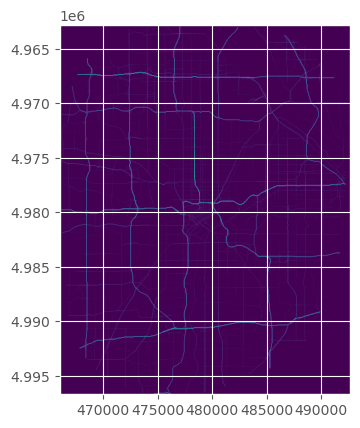

In [60]:
# Load rasterized aadt

from rasterio import plot

aadt_rast = rasterio.open('rasterized_aadt.tif') # Open

plot.show(aadt_rast) # Plot it

aadt_band = aadt_rast.read(1)

aadt_rast.close()

In [110]:
# Get some sort of focal statistic? 
# We want cummulative impact! 

from scipy.ndimage import convolve # <- this is cool
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html

# https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution
# Define weights kernel (tring gaussian?)

def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)



kernel = gkern(100, 10) # 5 implies gaussian kernel with 125 meter diameter and sigma of 3

focal_mean = convolve(aadt_band, kernel) / np.sum(kernel)
focal_sum = convolve(aadt_band, kernel)

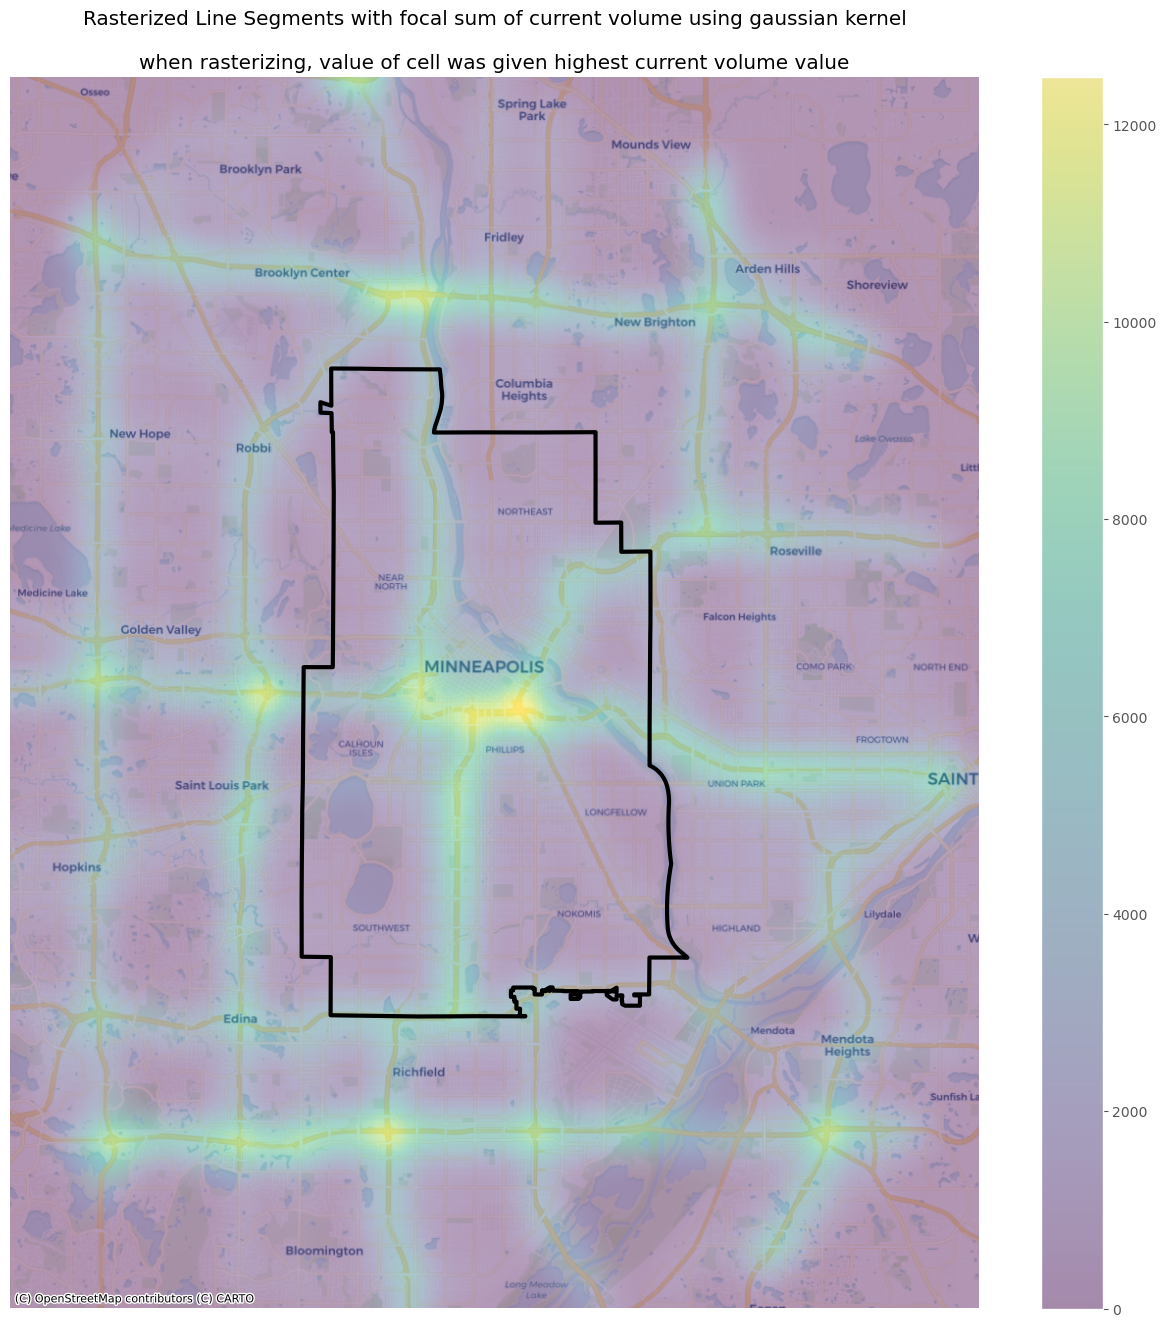

In [111]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], focal_sum.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Rasterized Line Segments with focal sum of current volume using gaussian kernel\n
when rasterizing, value of cell was given highest current volume value'''
ax.set_title(title) # Add title
ax.set_axis_off()

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Add basemap

contextily.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=contextily.providers.CartoDB.Voyager
                      ) 

plt.show()

In [106]:
# Looks cool!

## Interpolate!?

### Get Coordinates of Segment Centroids

In [14]:
# Get Coordinates

x = aadt_select.geometry.centroid.x
y = aadt_select.geometry.centroid.y

coords = np.array(list(zip(x,y)))

In [16]:
## First attempt

interpolator = interp.RBFInterpolator(y = coords,
                                      d = aadt_select['CURRENT_VO'].values,
                                      smoothing = 0.1,
                                      kernel = 'linear',
                                      epsilon = .04) # These worked okay?

Z = interpolator(raster.reshape(2, -1).T).reshape(raster[0].shape)

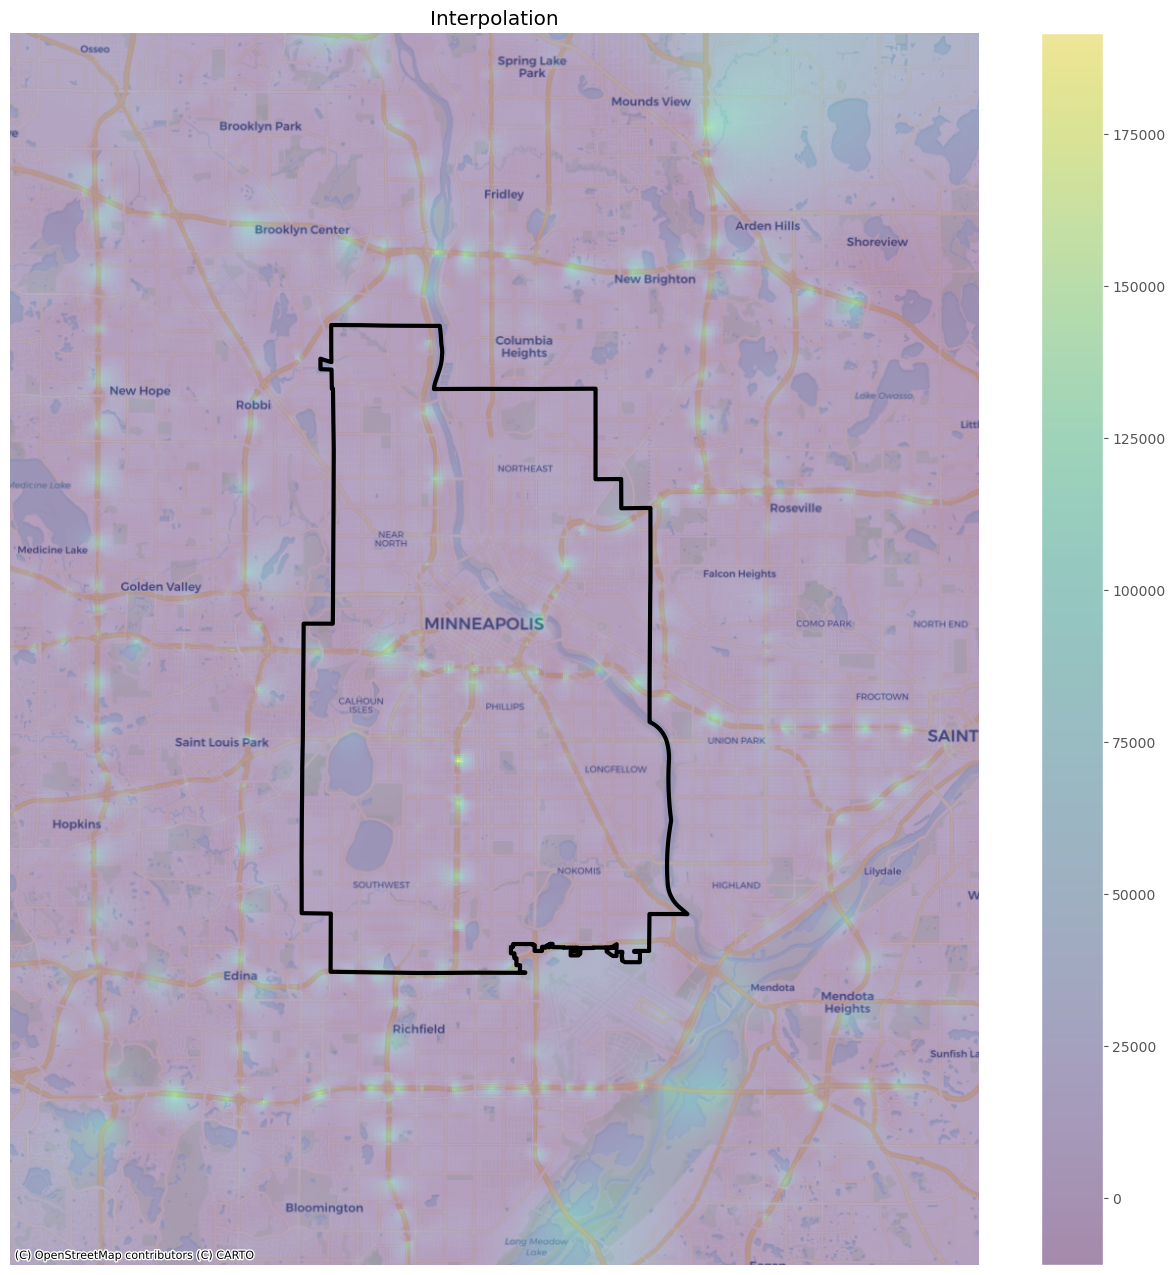



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [17]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], Z, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = 'Interpolation'
ax.set_title(title) # Add title
ax.set_axis_off()

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Add basemap

contextily.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=contextily.providers.CartoDB.Voyager
                      ) 

plt.show()
print('\n\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')

In [ ]:
# This one worked less well